# Setup and reading in data:


+ test models with sklearn.metrics accuracy_score
+ R2 score for simplest model (horizontal line), RMSE should be way worse for that than the linear fit model. sklearn.metris r2_score

std of original threat surface (RMS)
baseline model performance: histogram of crime response for training set and for test set. std of each. gives spread of data and baseline. why: tells you root mean square error if you just predict avg value everytime. 

next weeks crimes, same kde surfaces and crime, see how well predictions. 


what are we modelling: how geographical features affect crime

features attract/repel crime and magnitude. 

crime as a result of some geographic features. 

modeling process that explains crime. get the information and not too much noise. 

r2 can increase just by adding arbitrarily more features. 

validation set: more crime data, week after. predictors stay the same, crime will move. 

try: tuning boosting (it did the best), try svm with (rbf kernel) compare these to 

std: baseline for showing that spread of data is similar so we're not getting some crazy distribution. 

avg
testing and training similar shape and std.spread similar. standard baseline: zeroR baseline. most common with class and accuracy problems. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
# Others here as needed;

In [2]:
# "globals" -- bounding edges of crime in Chicago
lat_min = 41.644604096
lat_max = 42.022671246
lon_min = -87.928909442 
lon_max = -87.524529378

In [3]:
# Read in new da
vacant_df = pd.read_csv("data/311_Service_Requests_-_Vacant_and_Abandoned_Buildings_Reported.csv")
health_df = pd.read_csv("data/Chicago_Department_of_Public_Health_Clinic_Locations.csv")
connect_df = pd.read_csv("data/Connect_Chicago_Locations.csv") # internet access
bus_df = pd.read_csv("data/CTA_-_System_Information_-_Bus_Stop_Locations_in_Digital_Sign_Project.csv")
train_df = pd.read_csv("data/CTA_-_System_Information_-_List_of__L__Stops.csv")
farmer_df = pd.read_csv("data/Farmers_Markets_-_2012.csv")
library_df = pd.read_csv("data/Libraries_-_Locations__Hours_and_Contact_Information.csv")
police_df = pd.read_csv("data/Police_Stations_Map.csv")
crime_df = pd.read_csv("data/Chicago_Crimes_2012_to_2017.csv")

/Users/jacob/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## A little data cleanup:

In [4]:
# Crime dataset is quite large, so we'll only focus on last year:
crime_df = crime_df[crime_df["Year"] == 2016]

# Convert the string dates to datetime objects
crime_df["Date"] = pd.to_datetime(crime_df["Date"])

In [5]:
# Let's add a column that is 0-366 range, this will allow us to look at time slices throughout 2016
crime_df["Day"] = crime_df["Date"].apply(lambda x: x.timetuple().tm_yday)

In [6]:
def location_converter(s):
    """Takes a series of points -- tuples (lat, lon) --  as strings and converts them to floats"""
    return s.apply(lambda x: tuple(float(x) for x in x.strip(')(').replace(',','').split()))

# Not all DFs had the same keyname for the lat/lon points. Now they'll all be converted
# in to simple series of tuples. 
vacant_locations = location_converter(vacant_df["Location"].dropna())
health_locations = location_converter(health_df["Location"].dropna())
connect_locations = location_converter(connect_df["Location"].dropna())
bus_locations = location_converter(bus_df["Location"].dropna())
train_locations = location_converter(train_df["Location"].dropna())
farmer_locations = location_converter(farmer_df["Map"].dropna())
library_locations = location_converter(library_df["LOCATION"].dropna())
police_locations = location_converter(police_df["LOCATION"].dropna())

In [7]:
crime_week_df = crime_df[(crime_df["Day"] >= 100) & (crime_df["Day"] <= 107)]
crime_week_locations = location_converter(crime_week_df["Location"].dropna())

In [411]:
crime_next_week_df = crime_df[(crime_df["Day"] >= 108) & (crime_df["Day"] <= 114)]
crime_next_week_locations = location_converter(crime_next_week_df["Location"].dropna())

In [8]:
def make_grid(m1, m2, bandwidth):
    """ Returns a grid of the Chicago area and drops a gaussian curve over points found in m1/m2.
    m1: latitude points
    m2: longitude points
    bandwidth: size of the gaussian used. picked by experiment"""
    
    # mesh grid of values associated with the real (j). The grid is from min to max 
    # with nj being the step size. 
    X, Y = np.mgrid[lat_min:lat_max:200j, lon_min:lon_max:200j] 
    
    positions = np.vstack([X.ravel(), Y.ravel()]) # x row vector on top of y row vector, complete space
    values = np.vstack([m1, m2]) # raw data lat/lon
    kernel = stats.gaussian_kde(values, bw_method=bandwidth)
    Z = np.reshape(kernel(positions).T, X.shape)
    return Z

In [9]:
# This could be wrapped in a function, but for this analysis we only do it here and once. 
vacant_grid = make_grid([lat for lat,_ in vacant_locations], [lon for _,lon in vacant_locations], 0.26)
health_grid = make_grid([lat for lat,_ in health_locations], [lon for _,lon in health_locations], 0.26)
connect_grid = make_grid([lat for lat,_ in connect_locations], [lon for _,lon in connect_locations], 0.26)
bus_grid = make_grid([lat for lat,_ in bus_locations], [lon for _,lon in bus_locations], 0.26)
train_grid = make_grid([lat for lat,_ in train_locations], [lon for _,lon in train_locations], 0.26)
farmer_grid = make_grid([lat for lat,_ in farmer_locations], [lon for _,lon in farmer_locations], 0.26)
library_grid = make_grid([lat for lat,_ in library_locations], [lon for _,lon in library_locations], 0.26)
police_grid = make_grid([lat for lat,_ in police_locations], [lon for _,lon in police_locations], 0.26)
crime_week_grid = make_grid([lat for lat,_ in crime_week_locations], [lon for _,lon in crime_week_locations], 0.26)

In [412]:
crime_next_week_grid = make_grid([lat for lat,_ in crime_next_week_locations], [lon for _,lon in crime_next_week_locations], 0.26)

In [10]:
def plot_grid(grid, locations):
    """Plots out a given grid space with markers for locations of interest
    grids: in kde space (as output by make_grid()) 
    locations: lat/lon tuples. 
    """
    fig, ax = plt.subplots()
    ax.imshow(np.rot90(grid), cmap=plt.cm.gist_earth_r, extent=[lat_min, lat_max, lon_min, lon_max])
    ax.plot([lat for lat,_ in locations], [lon for _,lon in locations], 'k.', markersize=3)
    ax.set_xlim([lat_min, lat_max])
    ax.set_ylim([lon_min, lon_max])
    plt.show()

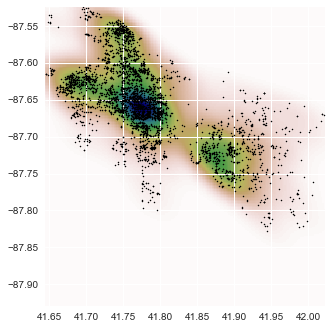

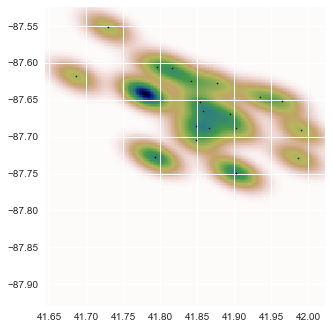

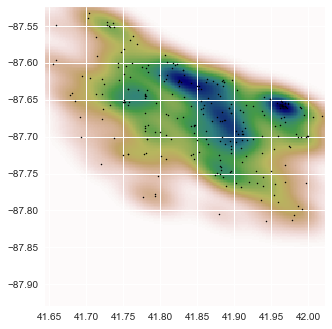

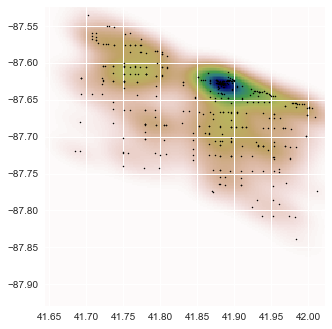

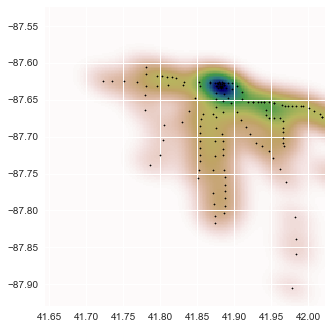

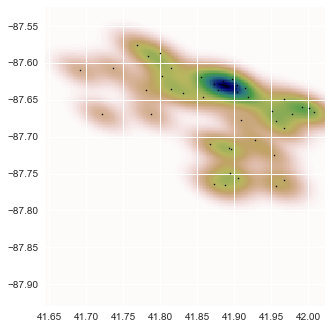

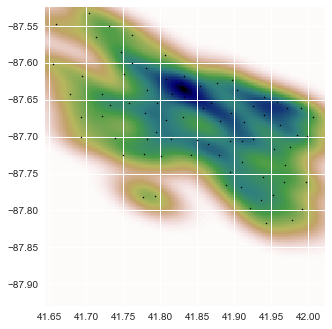

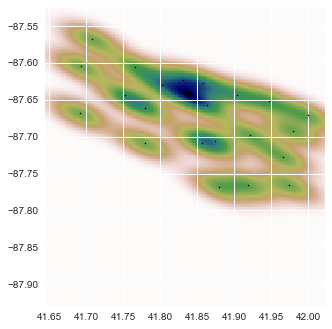

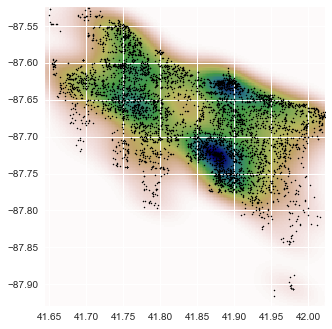

In [11]:
plot_grid(vacant_grid, vacant_locations[:4000]) # too many vacant lots to show all, good LABEL
plot_grid(health_grid, health_locations)
plot_grid(connect_grid, connect_locations)
plot_grid(bus_grid, bus_locations)
plot_grid(train_grid, train_locations)
plot_grid(farmer_grid, farmer_locations)
plot_grid(library_grid, library_locations)
plot_grid(police_grid, police_locations)
plot_grid(crime_week_grid, crime_week_locations)

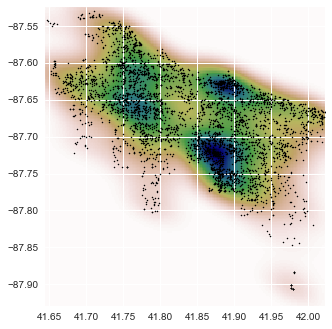

In [413]:
plot_grid(crime_next_week_grid, crime_next_week_locations)

In [12]:
# Turn the grids into vectors:
vacant_vector = vacant_grid.flatten()
health_vector = health_grid.flatten()
connect_vector = connect_grid.flatten()
bus_vector = bus_grid.flatten()
train_vector = train_grid.flatten()
farmer_vector = farmer_grid.flatten()
library_vector = library_grid.flatten()
police_vector = police_grid.flatten()
crime_week_vector = crime_week_grid.flatten()

# Make a dataframe with the flattened vectors for input to ML algorithms:
grid_df = pd.DataFrame({"Vacant lots" : vacant_vector, "Health clinics" : health_vector, 
                        "Connect hotspots": connect_vector, "Bus stops" : bus_vector, 
                        "Train stops" : train_vector, "Farmers markets": farmer_vector, 
                        "Libraries": library_vector, "Police stations": police_vector})

In [414]:
# To be used as the y values to test how well the model does. 
crime_next_week_vector = crime_next_week_grid.flatten()

Pair wise correalation show how much certain variables explain info, if two features have a high r2 score they more or less explain the data in the same way. 
multi colinearity. 

In [13]:
# Slooow: sub sample data to make it faster.
#g = sns.pairplot(grid_df, kind="reg")

In [14]:
#plt.show(g)

# Fitting models

In [15]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix # For comparisons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [73]:
# Get test and training sets 20% saved for testing:
X_train, X_test, y_train, y_test = train_test_split(grid_df, crime_week_vector, test_size=0.2) 

Let's take a quick look at the distribution of values in our test and training sets and get an intuition about the values we can expect from out models. 

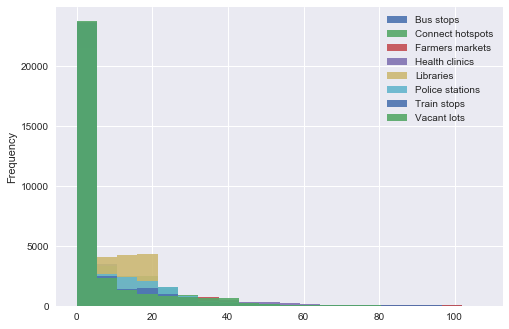

In [279]:
X_train.plot.hist(bins=20, alpha=0.9)
plt.figure(figsize=(16,10))
plt.show()

In [290]:
# Standard deviations for each feature kde vector.
[(x, X_train[x].std()) for x in X_train.columns.values.tolist()]

[('Bus stops', 11.407001566973118),
 ('Connect hotspots', 8.946125737580141),
 ('Farmers markets', 12.941850934870965),
 ('Health clinics', 13.096549514220067),
 ('Libraries', 7.335462123090535),
 ('Police stations', 10.427149077332405),
 ('Train stops', 12.351144009185903),
 ('Vacant lots', 12.516596774825514)]

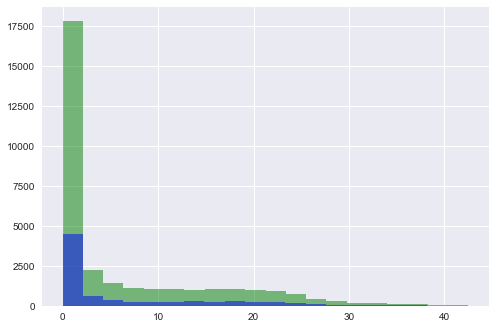

In [277]:
plt.hist(y_train, bins=20, color='green', alpha=0.5)
plt.hist(y_test, bins=20, color='blue', alpha=0.5)
plt.show()

In [294]:
# Standard deviations for the y values of the training and test sets. 
print("y_train standard deviation: {} \ny_test standard deviation:  {}".format(y_train.std(), y_test.std()))

y_train standard deviation: 8.99716939601919 
y_test standard deviation:  9.104145912726779


## Creating a baseline:
We'll make a baseline for models by performing regression with Police stations as the only feature. We'll also consider the histogram of the crime vector to understand 

In [204]:
base_linear_reg = LinearRegression()
base_linear_reg.fit(X_train["Police stations"].values.reshape(-1, 1), y_train)
base_linear_train_predictions = base_linear_reg.predict(X_train["Police stations"].values.reshape(-1,1))
base_linear_test_predictions = base_linear_reg.predict(X_test["Police stations"].values.reshape(-1,1))

In [205]:
# Training scores and errors:
base_linear_train_score = base_linear_reg.score(X_train["Police stations"].values.reshape(-1, 1), y_train)
base_linear_train_error = mean_squared_error(y_test, base_train_guesses[:8000])
base_train_r2 = r2_score(y_train[:8000], base_linear_train_predictions[:8000])

In [206]:
# Test scores and error:
base_test_predictions = base_linear_reg.predict(X_train["Police stations"].values.reshape(-1, 1))
base_linear_test_score = base_linear_reg.score(X_test["Police stations"].values.reshape(-1, 1), y_test)
base_linear_test_error = mean_squared_error(y_test, base_linear_test_predictions)

In [207]:
print("Base linear training error:      {}".format(base_linear_train_error))
print("Base linear training score(R^2): {}\n".format(base_linear_train_score))
print("Base linear test error:          {}".format(base_linear_test_error))
print("Base linear test score (R^2):    {}".format(base_linear_test_score))

Base linear training error:      131.32602462348515
Base linear training score(R^2): 0.5711973041946486

Base linear test error:          35.688635579769105
Base linear test score (R^2):    0.5694223079864665


In [302]:
base_linear_predictions.std()

6.7409667608280301

 We can simplify the process above by combining all the models error and R^2 scores into one function:

In [437]:
def test_model(model, X_train, y_train, X_test, y_test):
    """Prints out a models error and score on the test and training data. 
    Also returns the fitted model so it can be used elsewhere."""
    
    # Fit model and make predictions:
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    
    # Test:
    test_error = mean_squared_error(y_test, test_predictions)
    test_score = model.score(X_test, y_test)
    
    # Train:
    train_error = mean_squared_error(y_train, train_predictions)
    train_score = model.score(X_train, y_train)
    
    # Returns a tuple of results. May also have it return the model in the future.
    return (train_error, train_score, test_error, test_score, model)

def print_model_scores(res):
    """ res if form of: (training_error, training_score, test_error, test_score)"""
    train_e, train_s, test_e, test_s, m = res
    print("Training error:      {}\nTraining score(R^2): {}\n\nTest error:          {}\nTest score (R^2):    {}".format(train_e, train_s, test_e, test_s))

In [417]:
res = test_model(LinearRegression(), X_train, y_train, X_test, y_test)
print_model_scores(res)

Training error:      4.639080683976605
Training score(R^2): 0.9426913561708898

Test error:          4.648656797836151
Test score (R^2):    0.9439146977053399


## Linear regression with multiple features:

Now that we have a base line regression with a single feature (Police stations), we can add in the rest of our features and see how the model will change.

In [418]:
test_model(LinearRegression(), X_train, y_train, X_test, y_test)

(4.639080683976605,
 0.94269135617088984,
 4.6486567978361508,
 0.94391469770533987,
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))

In [419]:
linear_predictions.std()

8.8789236019745736

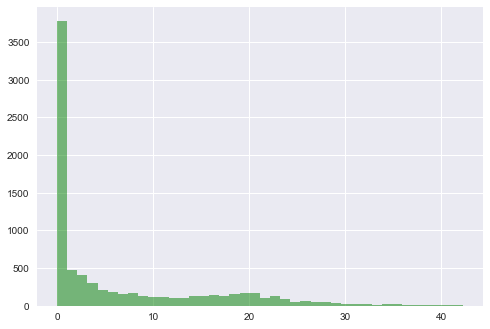

In [301]:
plt.hist(linear_predictions, bins=40, color='green', alpha=0.5)
plt.show()

Adjusted r2, aic, adjusted criteria. Need the holdout test set to help show this. 

## SVM:

In [22]:
from sklearn.svm import SVR

In [421]:
# We'll try SVR with both a linear kernel, and rbf which can generate curved decision boundaries. 
svr = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

In [422]:
linear_svr_res = test_model(svr, X_train[:1500], y_train[:1500], X_test[:1500], y_test[:1500])
rbf_svr_res = test_model(svr_rbf, X_train[:1500], y_train[:1500], X_test[:1500], y_test[:1500])

In [423]:
print_model_scores(linear_svr_res)

Training error:      4.876579761371994
Training score(R^2): 0.9421414019315548

Test error:          5.625040584755295
Test score (R^2):    0.9388076272696093


In [424]:
print_model_scores(rbf_svr_res)

Training error:      30.735579135799945
Training score(R^2): 0.635335090034738

Test error:          41.46283213322293
Test score (R^2):    0.5489438626931837


In [305]:
svr_test_predictions.std()

8.9540516058631887

# KNN:
similar kernel value in feature space (police station influence effect), likely to pick true lat/lon enighbors which will have similar kde values.  

In [153]:
from sklearn.neighbors import KNeighborsRegressor

In [325]:
neighbors_3 = KNeighborsRegressor(n_neighbors=3) 
neighbors_5 = KNeighborsRegressor(n_neighbors=5) 

In [326]:
neighbors_3_res = test_model(neighbors_3, X_train, y_train, X_test, y_test)
neighbors_5_res = test_model(neighbors_5, X_train, y_train, X_test, y_test)

In [328]:
print_model_scores(neighbors_3_res)

Training error:      0.012780160968080764
Training score(R^2): 0.9998421209410029

Test error:          0.02684301542442325
Test score (R^2):    0.9996761433033131


In [329]:
print_model_scores(neighbors_5_res)

Training error:      0.01515721909762288
Training score(R^2): 0.999812756076068

Test error:          0.02300300928892129
Test score (R^2):    0.9997224723644351


In [162]:
neighbor_regr = neighbors.fit(X_train, y_train)

In [303]:
neighbor_predictions.std()

9.0917476607442325

In [396]:
# num_neighbors = 5
# for i, weights in enumerate(['uniform', 'distance']): # 
#     knn = KNeighborsRegressor(num_neighbors, weights=weights)
#     y_prediction = knn.fit(X_train, y_train).predict(X_test)

#     plt.subplot(2, 1, i + 1)
#     plt.scatter(X_train["Police stations"][:20], y_train[:20], c='k', label='data')
#     plt.plot(X_test[:20], y_prediction[:20], c='g', label='prediction')
#     plt.axis('tight')
#     plt.legend()
#     plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (num_neighbors,
#                                                                 weights))

# plt.show()


I think what's happening is that there's soo much overlap in data/features/kde values that we're always finding correlation no matter where we look.
because test is from same set of kde as train. when searching for neighbors we're looking for lat/lon neighbors. lat/long neighbors will have same crime response. 

# Decision Trees:
leaf size, make plot of model complexity from singular leaf(avg) to overfit (leaf for every observation).
max depth leaf

In [331]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Initialize decision tree models of various depths:
tree_reg_2 = DecisionTreeRegressor(max_depth=2)
tree_reg_5 = DecisionTreeRegressor(max_depth=5)
tree_reg_10 = DecisionTreeRegressor(max_depth=10)

In [332]:
tree_reg_2_res = test_model(tree_reg_2, X_train, y_train, X_test, y_test)
tree_reg_5_res = test_model(tree_reg_5, X_train, y_train, X_test, y_test)
tree_reg_10_res = test_model(tree_reg_10, X_train, y_train, X_test, y_test)

In [333]:
print_model_scores(tree_reg_2_res)

Training error:      12.567728217132782
Training score(R^2): 0.8447452180289886

Test error:          13.488717824269573
Test score (R^2):    0.8372607723818905


In [334]:
print_model_scores(tree_reg_5_res)

Training error:      3.903482420320628
Training score(R^2): 0.9517785313603149

Test error:          3.8808841059461394
Test score (R^2):    0.9531777526889386


In [335]:
print_model_scores(tree_reg_10_res)

Training error:      0.446575694040051
Training score(R^2): 0.9944832502092762

Test error:          0.5200730833322628
Test score (R^2):    0.9937254012583628


In [304]:
tree_test_predictions.std()

8.8579886992960031

In [351]:
# Lets perform a little zip magic to group together training/test errors and scores across the different models:
tree_depth = [2,5,10]
z = list(zip(tree_reg_2_res, tree_reg_5_res, tree_reg_10_res))

In [389]:
def plot_error_score(x, x_label, y):
    """Plots error and r-squared values for test and training sets.
    """
    plt.plot(x, y[0])
    plt.xlabel(x_label)
    plt.ylabel("Training Error")
    plt.show()

    plt.plot(x, y[1])
    plt.xlabel(x_label)
    plt.ylabel("Training R-squared")
    plt.show()

    plt.plot(x, y[2])
    plt.xlabel(x_label)
    plt.ylabel("Test Error")
    plt.show()

    plt.plot(x, y[3])
    plt.xlabel(x_label)
    plt.ylabel("Test R-squared")
    plt.show()


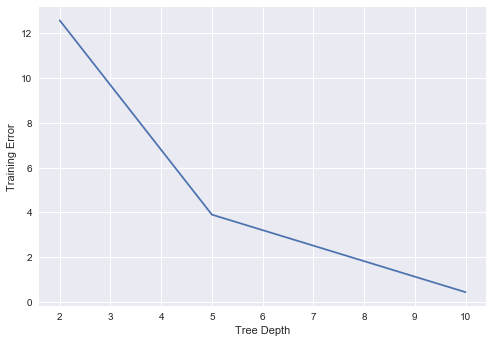

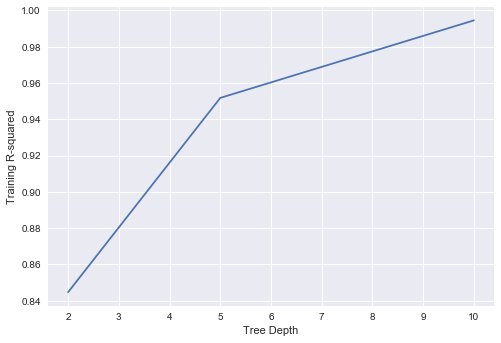

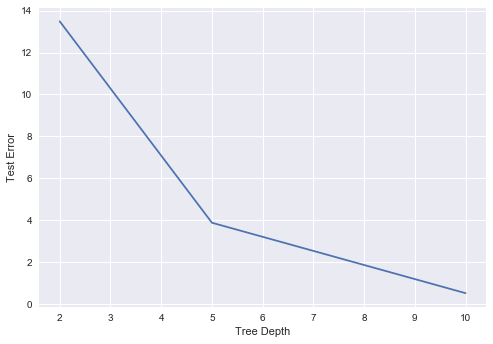

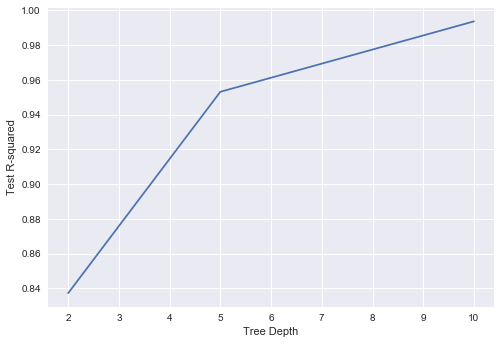

In [390]:
plot_error_score(tree_depth, "Tree Depth",z)

# Boosting:
next learner oversamples the previous learners errors. 

do a error vs estimators graph to see where diminishing returns are. 2/5/10 for max depth and 



In [361]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

In [359]:
# We'll be testing a variety of boosting models with various depth and estimators to get a sense of the best:
boost_2_20 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=20)
boost_2_100 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=100)
boost_2_500 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=500)

boost_5_20 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=20)
boost_5_100 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100)
boost_5_500 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=500)

boost_10_20 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=20)
boost_10_100 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=100)
boost_10_500 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=500)

boost_depth_2 = [boost_2_20, boost_2_100, boost_2_500]
boost_depth_5 = [boost_5_20, boost_5_100, boost_5_500]
boost_depth_10 = [boost_10_20, boost_10_100, boost_10_500]

In [425]:
boost_depth_2_res = [test_model(d, X_train, y_train, X_test, y_test) for d in boost_depth_2]
boost_depth_5_res = [test_model(d, X_train, y_train, X_test, y_test) for d in boost_depth_5]
boost_depth_10_res = [test_model(d, X_train, y_train, X_test, y_test) for d in boost_depth_10]

In [435]:
estimator_nums = [20, 100, 500]
boost_model_d_10_e_500 = boost_depth_10_res[-1][-1] # last tuple, last element: 500 estimators, model

In [428]:
def print_boosting_scores(res, n_estims):
    """res: a list of tuples in the form: [(test error, test score,...)...]
    n_estim: """
    for i, j in zip(res, n_estims):
        print("scores and error with {} estimators".format(j))
        print_model_scores(i)
        print("\n")

In [429]:
print("With a decision tree of depth 2: \n")
print_boosting_scores(boost_depth_2_res, estimator_nums)
print("With a decision tree of depth 5: \n")
print_boosting_scores(boost_depth_5_res, estimator_nums)
print("With a decision tree of depth 10: \n")
print_boosting_scores(boost_depth_10_res, estimator_nums)

With a decision tree of depth 2: 

scores and error with 20 estimators
Training error:      8.283484861103824
Training score(R^2): 0.8976703972387264

Test error:          8.392998036532976
Test score (R^2):    0.8987398182940604


scores and error with 100 estimators
Training error:      16.457890425833888
Training score(R^2): 0.7966882999361539

Test error:          16.445248562229075
Test score (R^2):    0.8015907009197215


scores and error with 500 estimators
Training error:      10.52993146826488
Training score(R^2): 0.8699190350053474

Test error:          10.489569640398393
Test score (R^2):    0.8734450165268215


With a decision tree of depth 5: 

scores and error with 20 estimators
Training error:      1.4803473512006675
Training score(R^2): 0.9817126053904708

Test error:          1.5400983702416375
Test score (R^2):    0.9814189589778445


scores and error with 100 estimators
Training error:      1.5288203061835348
Training score(R^2): 0.9811137972425432

Test error:      

In [382]:
boost_2_zip = list(zip(*boost_depth_2_res))
boost_5_zip = list(zip(*boost_depth_5_res))
boost_10_zip = list(zip(*boost_depth_10_res))

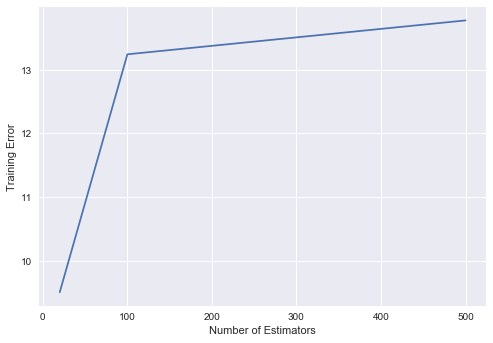

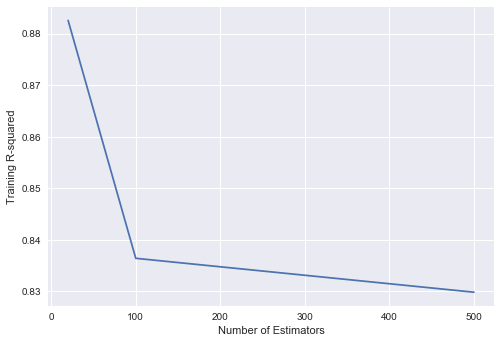

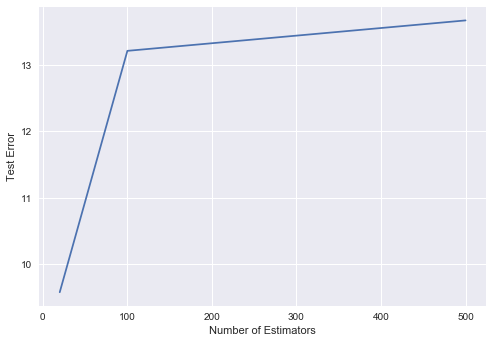

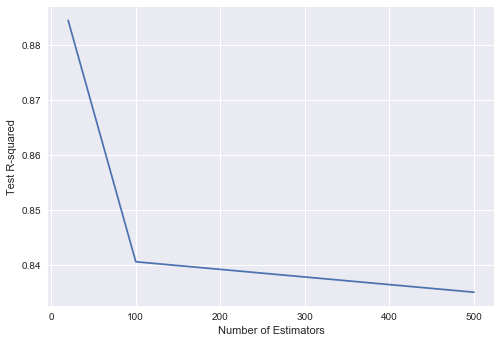

In [393]:
plot_error_score(estimator_nums, "Number of Estimators", boost_2_zip)
# Decision tree with depth of 2

With a depth of 2 for our decision tree regressor, we seem to do worse the more estimators we use.

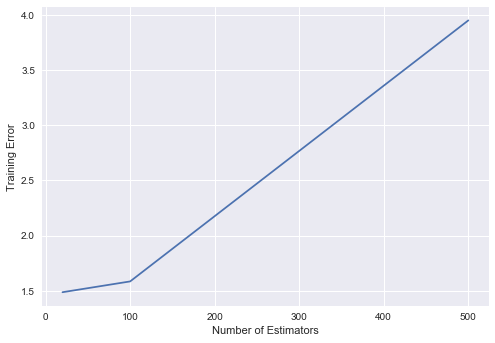

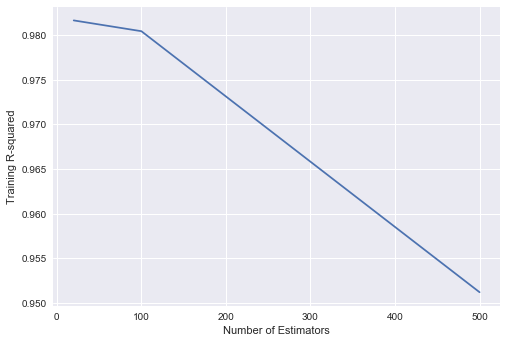

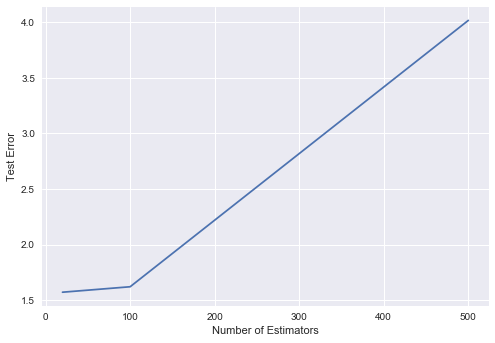

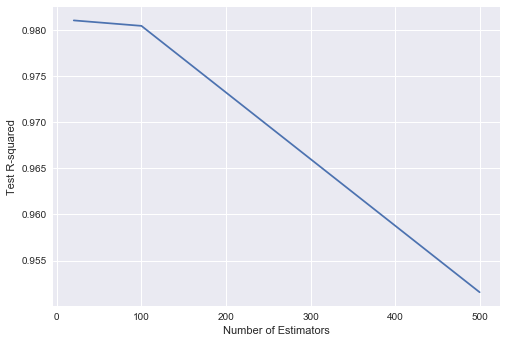

In [394]:
plot_error_score(estimator_nums, "Number of Estimators", boost_5_zip)
# Decision tree with depth of 5:

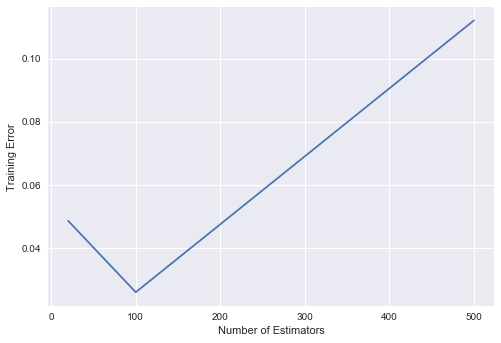

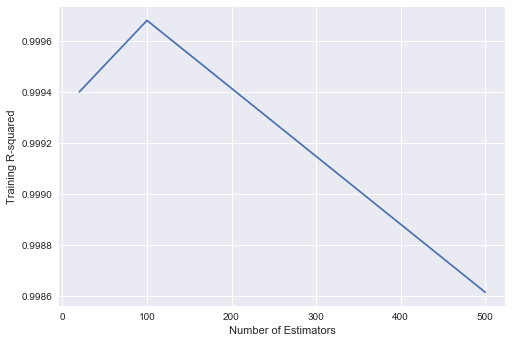

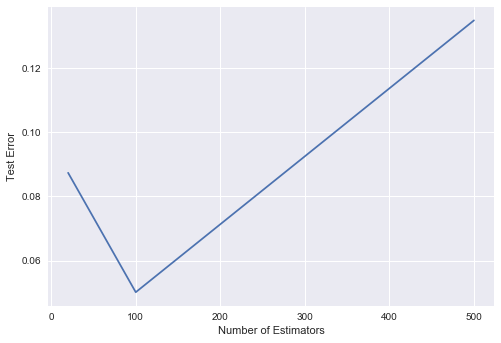

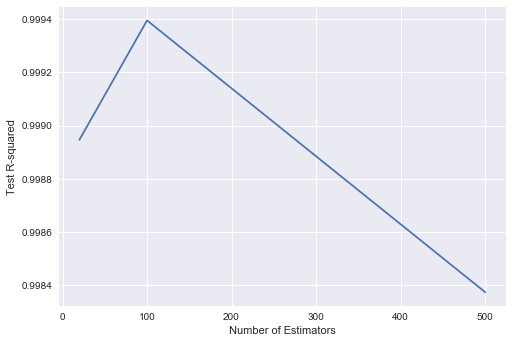

In [395]:
plot_error_score(estimator_nums, "Number of Estimators", boost_10_zip)
# Decision tree with depth of 10

Changing the depth of the original decision tree regressor has the most impact on the boosting algorithm. At a depth of 10 we start to see r-squared values very near to 1 and error scores below 1%.

# Predicting next weeks crime:
We've trained and tested quite a few models. The best performing one is an ensemble method using boosting and decision trees with a depth of 10 and 500 estimators. We'll test it on some unseen data (the following week of crime after the test/training set). 

In [436]:
boost_model_d_10_e_500

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=500,
         random_state=None)

In [438]:
next_weeks_predictions = boost_model_d_10_e_500.predict(X_train)

In [445]:
boosted_error = mean_squared_error(crime_next_week_vector[:32000], next_weeks_predictions)
#crime_next_week_vector.shape # 40000
#next_weeks_predictions.shape
boosted_error
#boosted_score = model.score(X_, y_test)

176.60960967036578

In [ ]:

# Test:
test_error = mean_squared_error(y_test, test_predictions)
test_score = model.score(X_test, y_test)

Boosting does better than decision trees as expected. can fit non linear and non piecewise functions. 

bump test set score up on boosting. 

given best parameters: what is prediction on a new training set (next week of crime).